# ОПФ для DTMF

Рассмотрим ОПФ на сигналах, полученных из технологии DTMF

In [1]:
from scipy.io import wavfile 
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

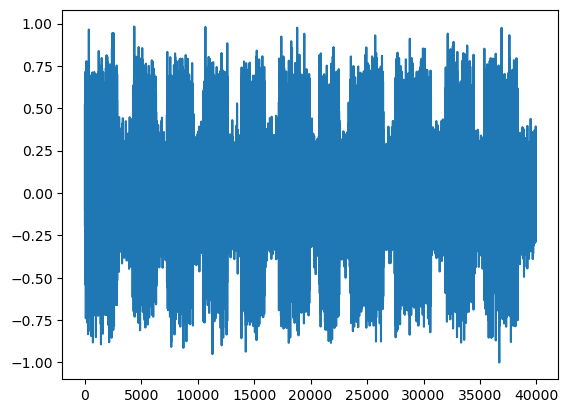

In [2]:
# подгрузка аудиофайла
filename = "source/signals/phoneNumber0.wav"
fs, audio_signal = wavfile.read(filename)
# график
plt.plot(audio_signal)

Построим спектр.

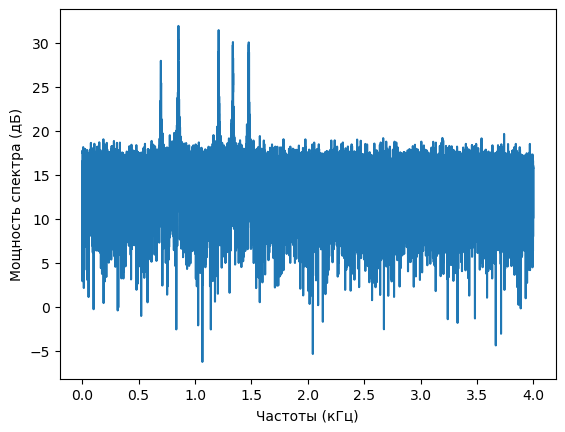

In [5]:
n = len(audio_signal) 
signalFFT = fft(audio_signal)
signalFFT = signalFFT[0:int(np.ceil((n+1)/2.0))] #берём половину спектра
signalFFT_mag = np.abs(signalFFT) # Magnitude
 

plt.figure()
freqAxis = np.arange(0,int(np.ceil((n+1)/2.0)), 1.0) * (fs / n);
plt.plot(freqAxis/1000.0, 10*np.log10(signalFFT_mag)) #Power spectrum
plt.xlabel('Частоты (кГц)'); plt.ylabel('Мощность спектра (дБ)');

Построим спектрограмму. Для этого надо создать экземпляр класса `signal.ShortTimeFFT` с необходимыми параметрами и использовать метод `stft()` для преобразования сигнала.



In [56]:
from scipy import signal

N = 512 # число точек для ДПФ
SFT = signal.ShortTimeFFT(signal.windows.boxcar(N), hop=int(N/2), fs=fs)#,  scale_to='magnitude')
Sx = SFT.stft(audio_signal)  

# Старый вариант STFT
#f, t, Sxx = signal.spectrogram(audio_signal, window = signal.windows.boxcar(512), fs = fs, nfft=512)

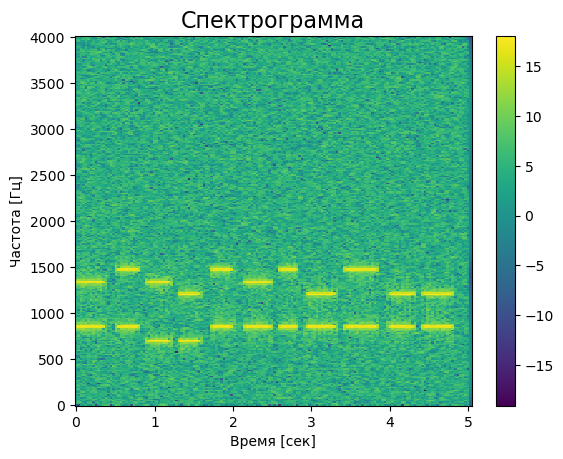

In [58]:
plt.figure()
plt.pcolormesh(SFT.t(len(audio_signal)), SFT.f, 10*np.log10(abs(Sx))) # dB spectrogram
#plt.pcolormesh(SFT.t(len(audio_signal)), SFT.f, abs(Sx))
plt.ylabel('Частота [Гц]')
plt.xlabel('Время [сек]')
plt.title('Спектрограмма',size=16);
plt.colorbar()

plt.show()

Можно использовать различные типы окон.

In [6]:
window = signal.windows.boxcar(51)
window

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

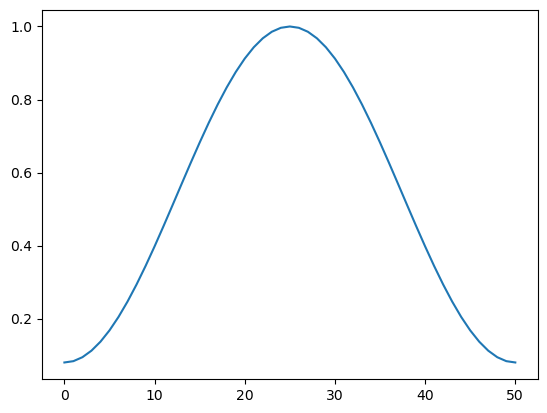

In [7]:
plt.plot(signal.windows.hamming(51))

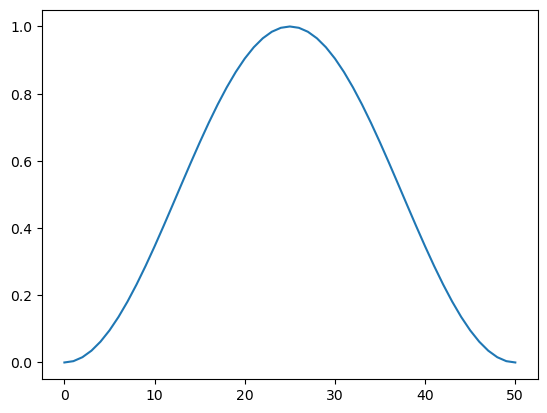

In [74]:
plt.plot(signal.windows.hann(51))

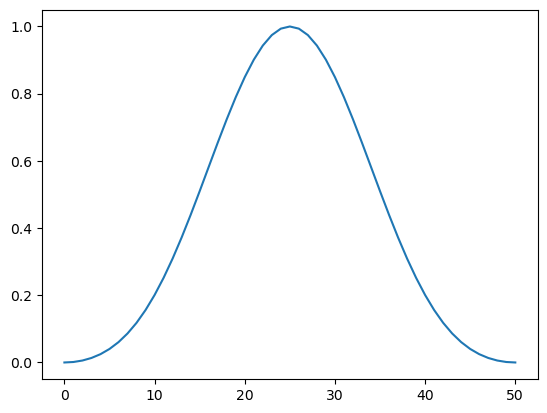

In [9]:
plt.plot(signal.windows.blackman(51))

# ОПФ в задачах классификации

ОПФ для аудио-сигналов часто используют, чтобы выделить признаки аудио-сигналов, которые далее можно использовать в задачах классификации или синтеза звуков.

Рассмотрим задачу класификации звуков с помощью свёрточных нейронных сетей, которые на вход принимают результат ОПФ.

Требуемые библиотеки:
    
    librosa
    torch
    
Рассмотрим датасет ESC-10 из 400 аудио-файлов с записью окружающих звуков. В датасете 10 классов, 40 треков на класс, 5 секунд на файл.

Ссылка на датасет: 
https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/YDEPUT/B3VNQW&version=2.0

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

Библиотека librosa содержит основные инструменты для работы с аудио-сигналами.

Загрузим сигнал и построим его спектрограмму.

In [64]:
data, fs = librosa.load("dataset/001 - Dog bark/1-30344-A.ogg", sr=44000) 
data.shape
time_sec = (len(data)/fs)
print('Длительность сигнала: ', time_sec)

D:\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
D:\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
D:\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Длительность сигнала:  5.001


Выведем график сигнала и озвучим сигнал.

In [66]:
import IPython
IPython.display.Audio(data, rate=fs)

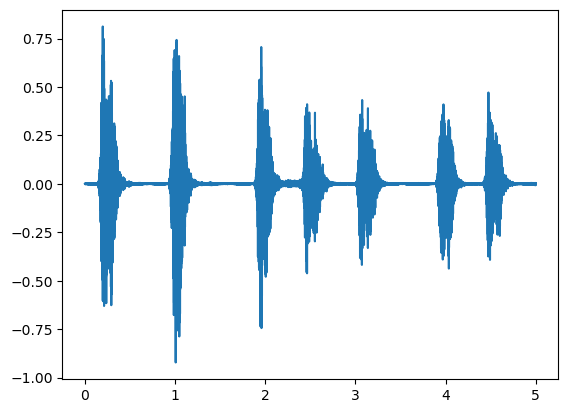

In [68]:
plt.plot(np.arange(0,len(data))/fs,data)

Проделаем ОПФ с помощью метода `librosa.stft()`.
Приведём значения в шкалу дБ, где максимум соответствует 0 дБ.

Метод по умолчанию имеет ширину окна 2048 точек. Расстояние между соседними окнами 512 точек. Также по умолчанию используется окно Ханна.

Размер матрицы ОПФ сигнала: (1025, 430)


Text(0.5, 1.0, 'ОПФ')

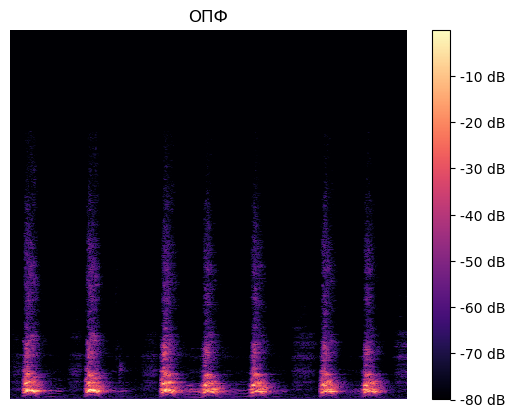

In [76]:
freq = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
print('Размер матрицы ОПФ сигнала:', freq.shape)
plt.axis('off') # no axis
librosa.display.specshow(freq)
plt.colorbar(format='%+2.0f dB')
plt.title('ОПФ')

### Задача

Сформировать модель и обучить на датасете ESC-10.

Цель: обучить модель с точностью accuracy 80% на тестовой выборке.

Основные шаги:

1. Подгрузить файлы, как набор пар (файл, метка класса)
2. Применить STFT к аудио-сигналам, подобрав подходящие параметры. Обеспечить одинаковый размер массивов на выходе.
3. Разделить данные на обучающую и тестовую выборки.
4. Подобрать архитектуру свёрточной ИНС и обучить модель.

Функция ошибки - это кросс-энтропия.

    loss_fn = nn.CrossEntropyLoss()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test =  train_test_split(features_convolution, target, test_size=0.2, random_state=42, stratify = target)